# Amortized Inference for a NLME Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import Problem, optimize, sample, visualize, profile, engine
from pypesto.objective import Objective, AggregatedObjective, NegLogParameterPriors
from scipy import stats

from inference.helper_functions import (create_mixed_effect_model_param_names,
                                        analyse_correlation_in_posterior,
                                        create_fixed_params)
from inference.inference_functions import run_population_optimization
from inference.ploting_routines import (plot_real_vs_synthetic,
                                        plot_real_and_estimated,
                                        plot_normal_distributions,
                                        visualize_pesto_result)

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 'pharmacokinetic_model'][0]

# Load individual model

INFO:root:Performing 2 pilot runs with the SimpleFroehlichModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 180, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


using 2 layers of MultiConv1D, a bidirectional LSTM with 256 units and a dense layer with output dimension 12 as summary network
using a 6-layer cINN as inference network with 2 layers of design spline
Using normal prior
prior mean: [-3. -3.  5.  0.  0. -1.]
prior covariance diagonal: [ 5.  5. 11.  2.  6.  2.]
Using the model SimpleFroehlichModel


INFO:root:Loaded loss history from ../networks/amortizer-simple-fro-sequence-summary-Bi-LSTM-6layers-2coupling-spline-500epochs/history_416.pkl.
INFO:root:Networks loaded from ../networks/amortizer-simple-fro-sequence-summary-Bi-LSTM-6layers-2coupling-spline-500epochs/ckpt-416
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  450420    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  605484    
 Network)                                                        
                                                                 
Total params: 1055904 (4.03 MB)
Trainable params: 1055832 (4.03 MB)
Non-trainable params: 72 (288.00 Byte)
_________________________________________________________________
None


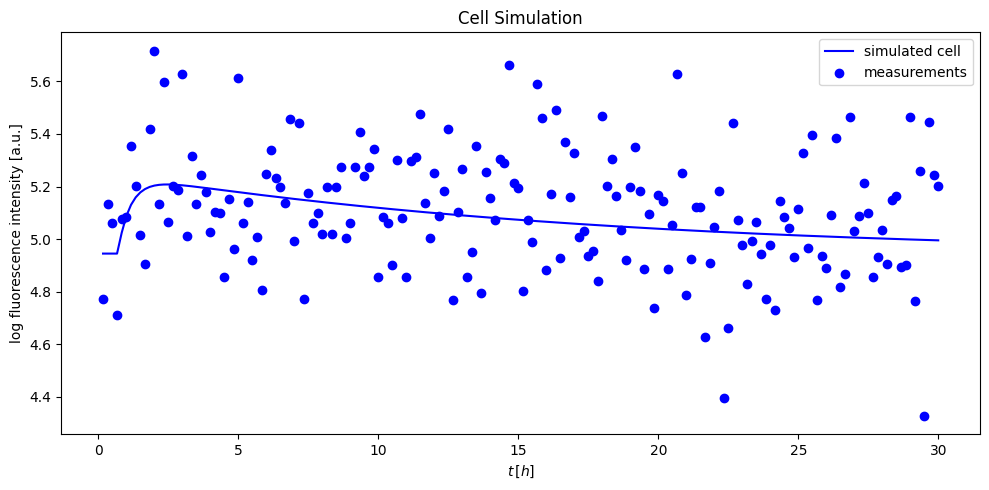

In [3]:
prior_type = ['normal', 'uniform'][0]
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True, prior_type=prior_type)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True, prior_type=prior_type)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True, prior_type=prior_type)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

## Load Data

In [4]:
# define how many data points are used for optimization
n_data = 50
load_real_data = False
# load data
true_pop_parameters = None
if 'Froehlich' in individual_model.name:
    obs_data = individual_model.load_data(n_data=n_data, synthetic=not load_real_data, 
                                          load_egfp=True, load_d2egfp=False)  # if both are loaded, a 2d-list is returned
    if not load_real_data:
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_data)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data = model_sde.load_data(n_data=n_data, synthetic=True)
    #true_pop_parameters_sde = model_sde.load_synthetic_parameter(n_data=n_data)
else:
    if load_real_data:
        obs_data = individual_model.load_data(n_data=n_data)
    else:
        synthetic_fixed_indices = [3]
        obs_data, true_pop_parameters = individual_model.load_data(n_data=n_data, synthetic=True, 
                                                                   return_synthetic_params=True)


n_data = len(obs_data)  # in case less data is available
print(len(obs_data), 'individuals')

50 individuals


# Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.
$\beta$ is called ```theta_population``` in the code.

$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

## Define Objective Function

- you have to choose the covariance format (diag or cholesky)
- if you want to use covariates, you have to specify the covariate mapping to the parameters of the log-normal distribution
- a covariate mapping takes in population parameters (beta, psi_inverse), covariates and covariate parameters and returns the transformed population parameters and covariance matrix
- the transformed parameters are then individual specific and used in the likelihood calculation

In [5]:
cov_type = ['diag', 'cholesky'][0]
use_covariates = False

mixed_effect_params_names = create_mixed_effect_model_param_names(individual_model.param_names, 
                                                                  cov_type=cov_type)

In [6]:
# build covariate mapping if needed
covariates_bounds = None
covariate_mapping = None
n_covariates_params = 0
covariates = None
covariates_names = []

if use_covariates and 'fröhlich' in model_name:
    # experiment specific gamma
    gamma_index = [ni for ni, name in enumerate(mixed_effect_params_names) if 'gamma' in name]
    gamma_index_cov = [ni for ni, name in enumerate(mixed_effect_params_names[individual_model.n_params:]) if 'gamma' in name]
    covariates_names = [name + '-d2eGFP' for name in mixed_effect_params_names if 'gamma' in name]
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-5, 5]] * n_covariates_params)
    
    mixed_effect_params_names = mixed_effect_params_names + covariates_names

In [7]:
if use_covariates and 'fröhlich' in model_name:
    # obs_data consists of two groups, first group is eGFP, second group is d2eGFP
    if covariates is None:
        assert len(obs_data) == 2, 'you should load two groups of data'
        covariates = np.concatenate((np.zeros(len(obs_data[0])), np.ones(len(obs_data[1]))))[:, np.newaxis]
        obs_data = np.concatenate((obs_data[0], obs_data[1]))
        n_data = len(obs_data)
        
    from inference.nlme_objective import get_inverse_covariance
    def multi_experiment_mapping(beta: np.ndarray,
                                 psi_inverse_vector: np.ndarray,
                                 covariates: np.ndarray,
                                 covariates_params: np.ndarray):
        """individual_param_i = gamma_{eGFP} * (1-c) + gamma_{d2eGFP} * c + random_effect_{eGFP}, c in {0,1}"""        
        # add param_of_cov*covariates to parameter gamma
        # covariate_params[0] > 0 expected since lifetime of d2eGFP is lower than eGFP
        beta_transformed = np.repeat(beta[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_vector_transformed = np.repeat(psi_inverse_vector[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_transformed = np.zeros((covariates.shape[0], beta.shape[0], beta.shape[0]))
                   
        # flatten since only one covariate     
        beta_transformed[:, gamma_index[0]] = beta_transformed[:, gamma_index[0]] * (1-covariates.flatten()) + covariates_params[0] * covariates.flatten()
        for i, c_i in enumerate(gamma_index_cov):
            psi_inverse_vector_transformed[:, c_i] = psi_inverse_vector[c_i] * (1-covariates.flatten()) + covariates_params[1+i] * covariates.flatten()
        
        for s_id in range(covariates.shape[0]):
            psi_inverse = get_inverse_covariance(psi_inverse_vector_transformed[s_id],
                                                 covariance_format=cov_type,
                                                 param_dim=beta.shape[0])
            psi_inverse_transformed[s_id, :, :] = psi_inverse
        return beta_transformed, psi_inverse_transformed
    
    covariate_mapping = multi_experiment_mapping

### Analyse correlations between parameters

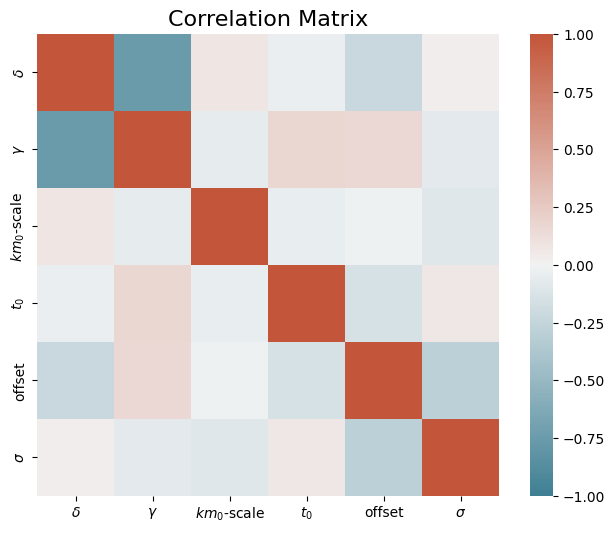

Parameter pairs of high correlation in individual posterior: []


In [8]:
high_correlation_pairs = analyse_correlation_in_posterior(model=individual_model, 
                                                          mixed_effect_params_names=mixed_effect_params_names, 
                                                          obs_data=obs_data,
                                                          threshold_corr=0.3)
print('Parameter pairs of high correlation in individual posterior:', np.array(mixed_effect_params_names)[high_correlation_pairs])

## Fixed and Random Effects

Decide which parameters to fix
- a fixed effect is modeled as a random effect with variance 0 (all parameters follow a normal distribution)
- variance of error parameters in the individual model are usually supposed to be a fixed parameter in the population model
- correlations with these error parameters are usually fixed to 0


In [9]:
if 'Froehlich' in individual_model.name:
    # fix variance of error parameters and correlations with sigma if cholesky covariance is used
    fix_names = ['var-$\sigma$'] + [name for name in mixed_effect_params_names if '\sigma' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
elif 'Pharmacokinetic' in individual_model.name:
    fix_error_var = ['var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fix_error_var_val = [0] * len(fix_error_var)
    # fix variance of fixed parameters
    fixed_effects_var = ['var-$\\theta_1$', 'var-$\\theta_5$', 'var-$\\theta_7$', 'var-$\\theta_8$', 
                         'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fixed_effects_var_val = [0] * len(fixed_effects_var)
    # fix mean of random effect
    random_effect_mean = ['pop-$\eta_4$']
    random_effect_mean_val = [0]
    
    # put all fixed parameters together
    fix_names = fix_error_var + fixed_effects_var + random_effect_mean
    fixed_values = fix_error_var_val + fixed_effects_var_val + random_effect_mean_val
    
    # if correlations are used, only allow the same as in the original model
    # hence correlations with the error parameter are fixed as well
    if cov_type == 'cholesky':
        non_fix_corr = ['corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\eta_4$']
        fixed_corr = [x for x in mixed_effect_params_names if 'corr_' in x and x not in non_fix_corr]
        fix_names += fixed_corr
        fixed_values += [0] * len(fixed_corr)

else:
    raise NotImplementedError('model not yet implemented')
    
# "fix" is here in the context of parameters which are not optimized
fixed_indices, fixed_values = create_fixed_params(fix_names=fix_names, 
                                                  fixed_values=fixed_values,
                                                  params_list=mixed_effect_params_names, 
                                                  fix_low_correlation=False,  # only applies to cholesky covariance
                                                  high_correlation_pairs=high_correlation_pairs)
print(mixed_effect_params_names)
# note: inf values in fixed_values will be set to upper or lower bound respectively

['pop-$\\delta$', 'pop-$\\gamma$', 'pop-$k m_0$-scale', 'pop-$t_0$', 'pop-offset', 'pop-$\\sigma$', 'var-$\\delta$', 'var-$\\gamma$', 'var-$k m_0$-scale', 'var-$t_0$', 'var-offset', 'var-$\\sigma$']


In [10]:
fixed_indices, unique_indices = np.unique(np.array(fixed_indices), return_index=True)
fixed_values = np.array(fixed_values)[unique_indices]

# Run Population Optimization

In [12]:
%%time
pypesto_result, obj_fun_amortized, pesto_problem = run_population_optimization(
    individual_model=individual_model,
    data=obs_data,
    param_names=mixed_effect_params_names,
    cov_type=cov_type,
    n_multi_starts=10,
    n_samples_opt=100,
    covariates_bounds=covariates_bounds,
    covariates=covariates,
    n_covariates_params=n_covariates_params,
    covariate_mapping=covariate_mapping,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    #file_name=f'../Experiments/results_nonmem/{model_name}_{cov_type}.hdf5',
    verbose=True,
    pesto_multi_processes=10,
)

print(pypesto_result.optimize_result.summary())

Multi-start optimization:   0%|          | 0/1 [00:00<?, ?it/s]

                              free    lb_full    ub_full
pop-$\delta$                  True  -9.708204   3.708204
pop-$\gamma$                  True  -9.708204   3.708204
pop-$k m_0$-scale             True  -4.949874  14.949874
pop-$t_0$                     True  -4.242641   4.242641
pop-offset                    True  -7.348469   7.348469
pop-$\sigma$                  True  -5.242641   3.242641
$-\log$ (var-$\delta$)        True -10.728180   6.907755
$-\log$ (var-$\gamma$)        True -10.728180   6.907755
$-\log$ (var-$k m_0$-scale)   True -10.728180   6.907755
$-\log$ (var-$t_0$)           True -10.728180   6.907755
$-\log$ (var-offset)          True -10.728180   6.907755
$-\log$ (var-$\sigma$)       False -10.728180   6.907755
                        fixed value
$-\log$ (var-$\sigma$)     6.907755



Multi-start optimization: 100%|██████████| 1/1 [00:18<00:00, 18.92s/it]


## Optimization Result 

* number of starts: 10 
* best value: -720.1937605231376, id=batch_0_4
* worst value: -718.554137666551, id=batch_0_6
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 14.256s
	* Maximum execution time: 15.632s,	id=batch_0_9
	* Minimum execution time: 11.651s,	id=batch_0_5
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      10 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 4 time(s)
* number of plateaus found: 2

A summary of the best run:

### Optimizer Result

* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>
* message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 
* number of evaluations: 139
* time taken to optimize: 13.461s
* startpoint: [-1.88809616 -2.08914407 -3.61534187  2.19738195  4.27808564 -2.15234406
 -5.74937604 

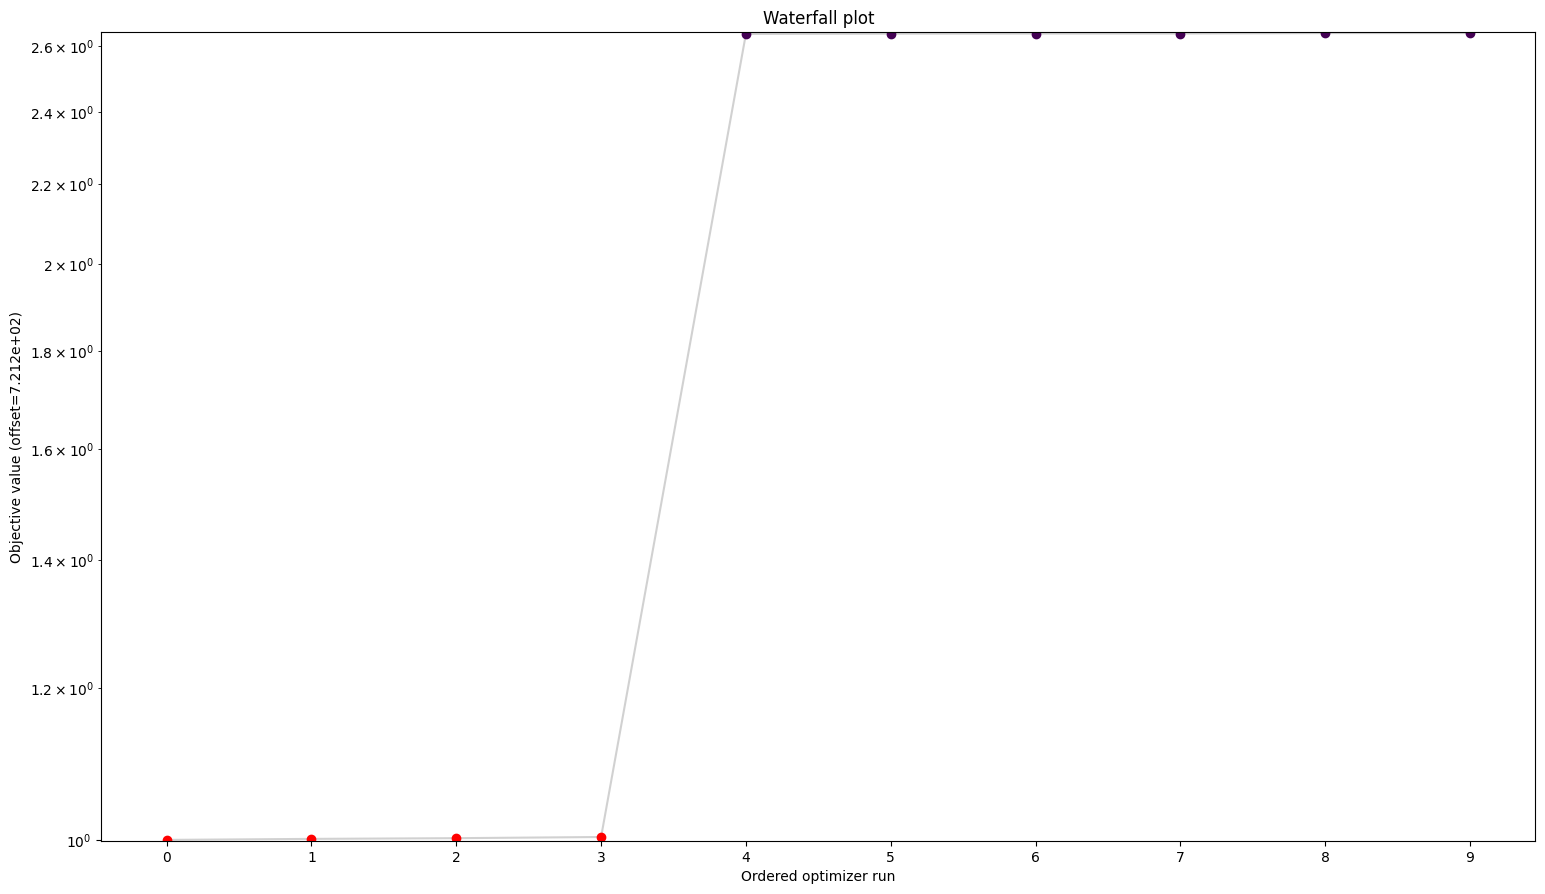

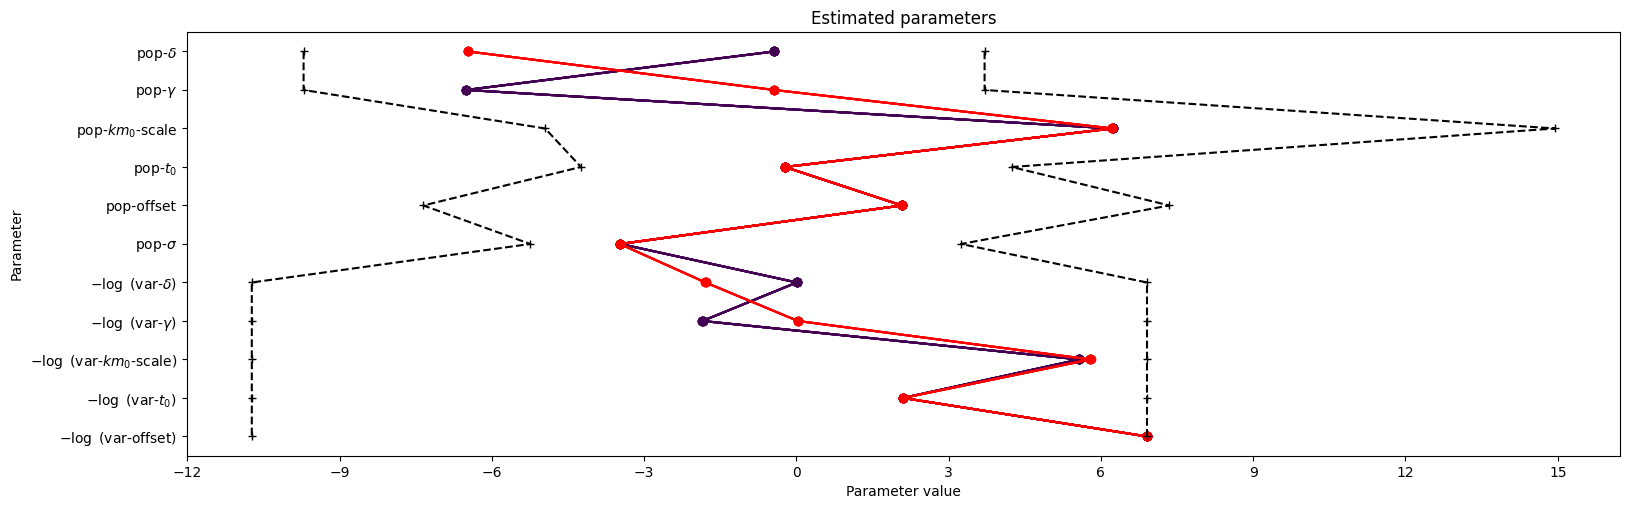

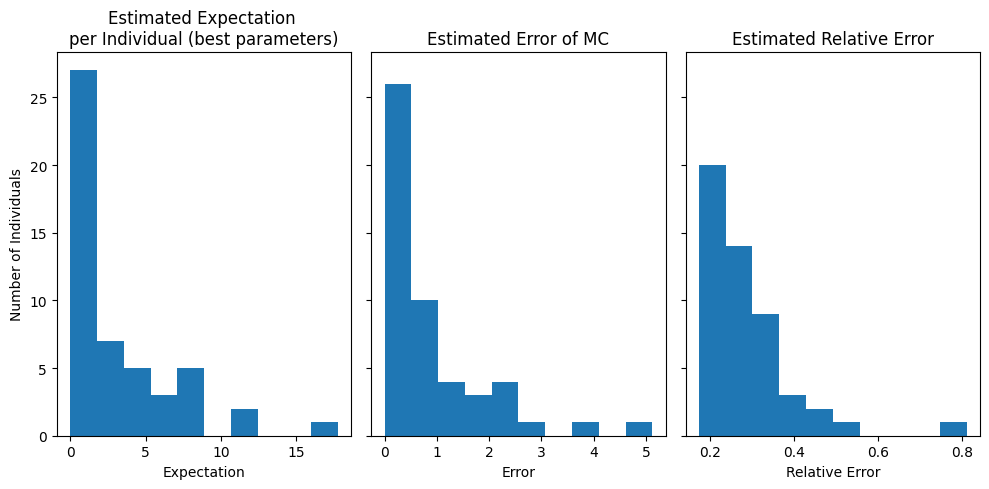

In [14]:
visualize_pesto_result(pypesto_result, use_batch_coloring=False, obj_fun_amortized=obj_fun_amortized)

In [15]:
# show best result
results = pypesto_result.optimize_result.x
estimated_beta, psi_inverse, estimated_psi_vector, estimated_covariates_params = obj_fun_amortized.get_params(results[-1])
estimated_psi = np.linalg.inv(psi_inverse)
estimated_var = estimated_psi.diagonal()
estimated_corr = estimated_psi[np.tril_indices(obj_fun_amortized.param_dim, k=-1)]

display(pd.DataFrame(estimated_beta,
                     index=mixed_effect_params_names[:individual_model.n_params],
                     columns=['estimated population parameters']))
display(pd.DataFrame(estimated_var,
                     index=mixed_effect_params_names[individual_model.n_params:individual_model.n_params*2],
                     columns=['estimated population parameters']))
if cov_type == 'cholesky':
    display(pd.DataFrame(estimated_corr,
                         index=mixed_effect_params_names[individual_model.n_params*2:],
                         columns=['estimated population parameters']))
    
display(pd.DataFrame(np.var([r for r in results], axis=0),
                     index=pypesto_result.problem.x_names,
                     columns=['variance of multi-start results']))

,estimated population parameters
pop-$\delta$,-0.435261
pop-$\gamma$,-6.505077
pop-$k m_0$-scale,6.231640
pop-$t_0$,-0.226818
pop-offset,2.079228
pop-$\sigma$,-3.467414


,estimated population parameters
var-$\delta$,0.990870
var-$\gamma$,6.350299
var-$k m_0$-scale,0.003789
var-$t_0$,0.122292
var-offset,0.001000
var-$\sigma$,0.001000


,variance of multi-start results
pop-$\delta$,8.734733e+00
pop-$\gamma$,8.838465e+00
pop-$k m_0$-scale,8.824727e-06
pop-$t_0$,2.826208e-07
pop-offset,1.877505e-06
pop-$\sigma$,2.476506e-05
$-\log$ (var-$\delta$),7.759708e-01
$-\log$ (var-$\gamma$),8.476378e-01
$-\log$ (var-$k m_0$-scale),1.137118e-02
$-\log$ (var-$t_0$),3.399202e-06


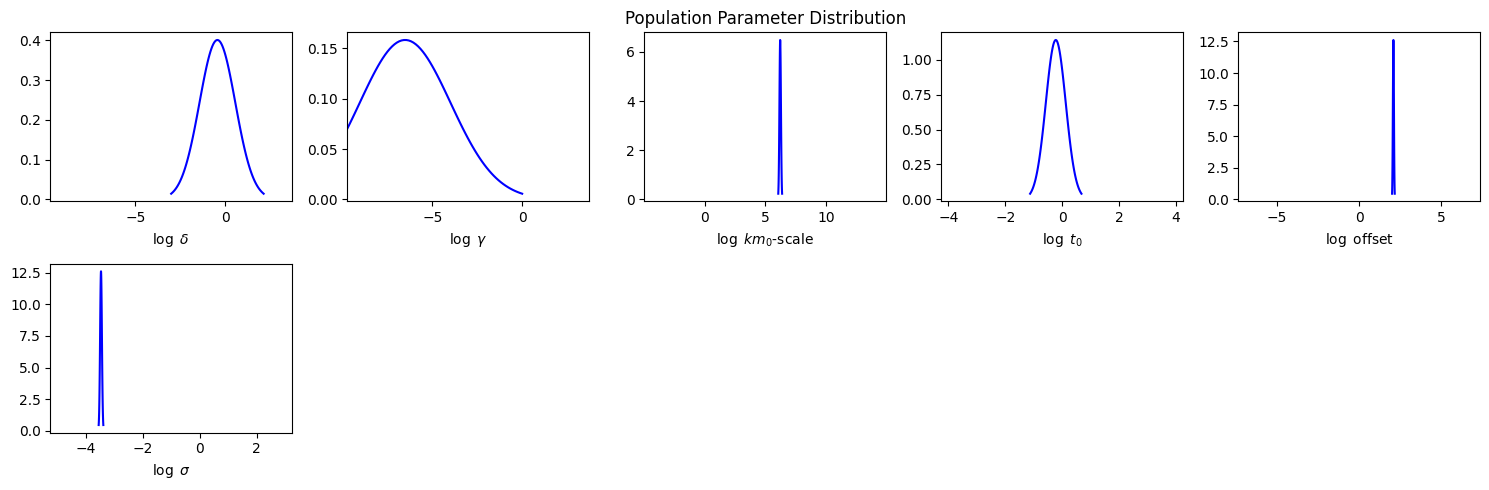

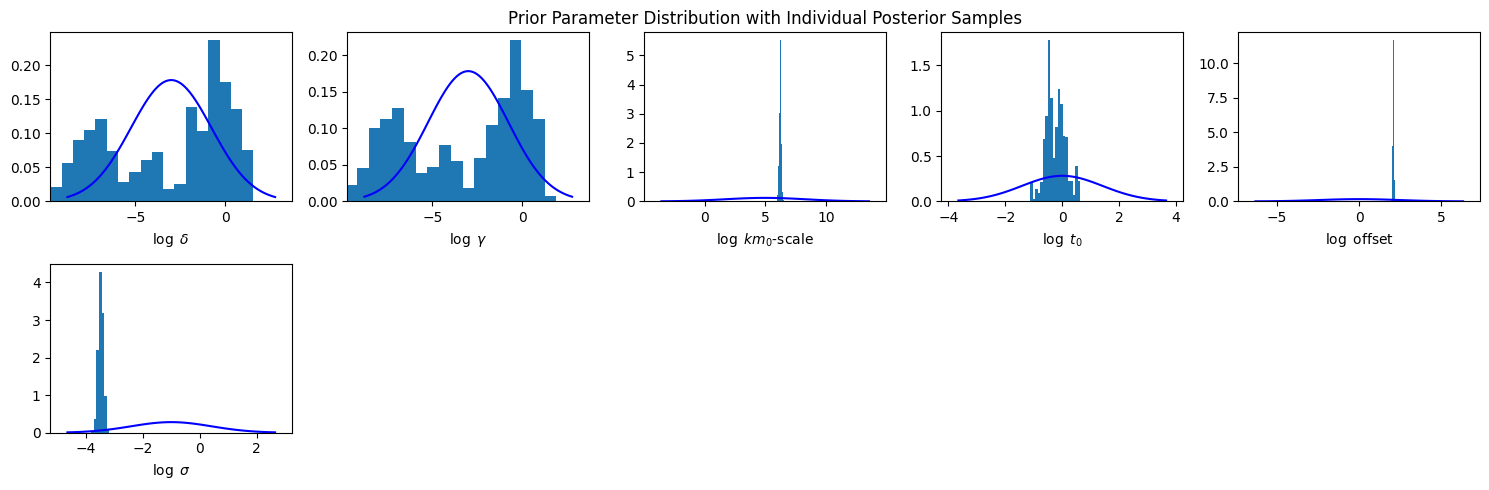

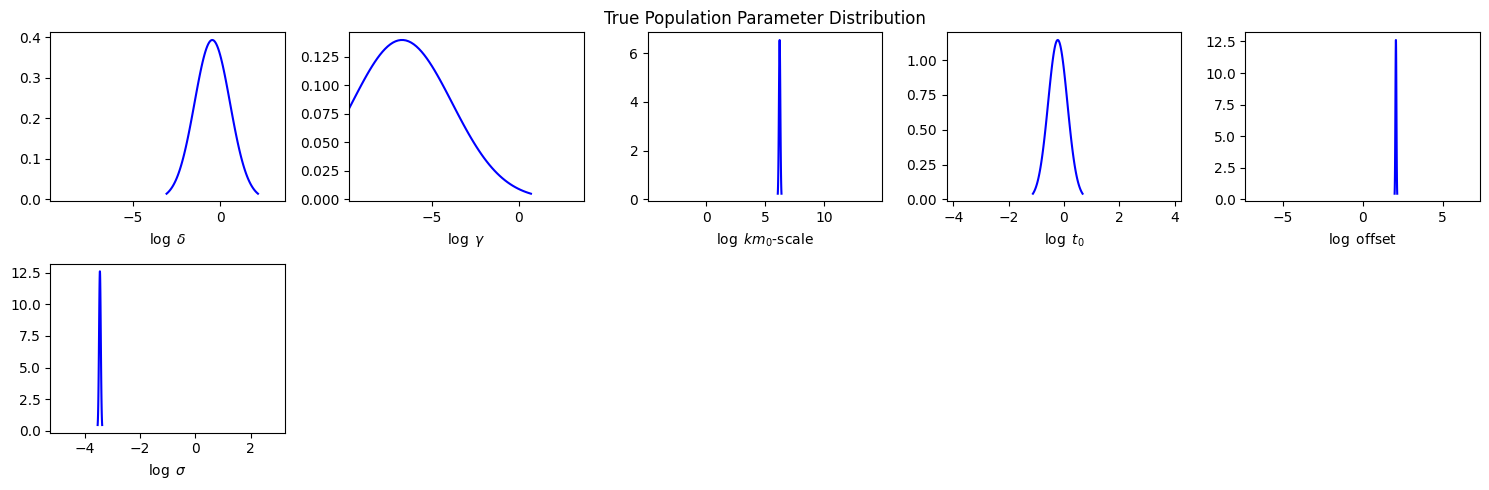

In [16]:
plot_normal_distributions(estimated_beta, estimated_psi, 
                          title='Population Parameter Distribution',
                          lb=pypesto_result.problem.lb_full,
                          ub=pypesto_result.problem.ub_full,
                          param_names_plot=individual_model.log_param_names)

plot_normal_distributions(individual_model.prior_mean, individual_model.prior_cov, 
                          title='Prior Parameter Distribution with Individual Posterior Samples',
                          posterior_samples=obj_fun_amortized.param_samples,
                          lb=pypesto_result.problem.lb_full,
                          ub=pypesto_result.problem.ub_full,
                          param_names_plot=individual_model.log_param_names)

if true_pop_parameters is not None:
    if true_pop_parameters.ndim == 2:
        true_mean = np.mean(true_pop_parameters, axis=0)
        true_cov = np.diag(np.var(true_pop_parameters, axis=0))
    else:
        true_mean = true_pop_parameters[:individual_model.n_params]
        true_cov = np.diag(true_pop_parameters[individual_model.n_params:])
    true_cov[true_cov < 0.001] = 0.001  # smaller cannot be estimated
    
    plot_normal_distributions(true_mean, 
                              true_cov, 
                              title='True Population Parameter Distribution',
                              #posterior_samples=obj_fun_amortized.param_samples,
                              lb=pypesto_result.problem.lb_full,
                              ub=pypesto_result.problem.ub_full,
                              param_names_plot=individual_model.log_param_names)

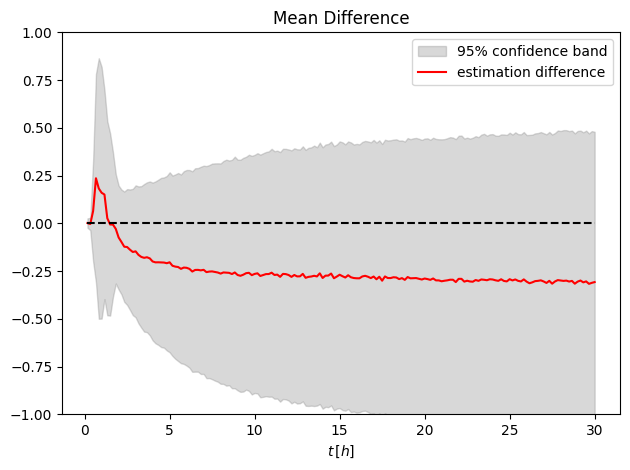

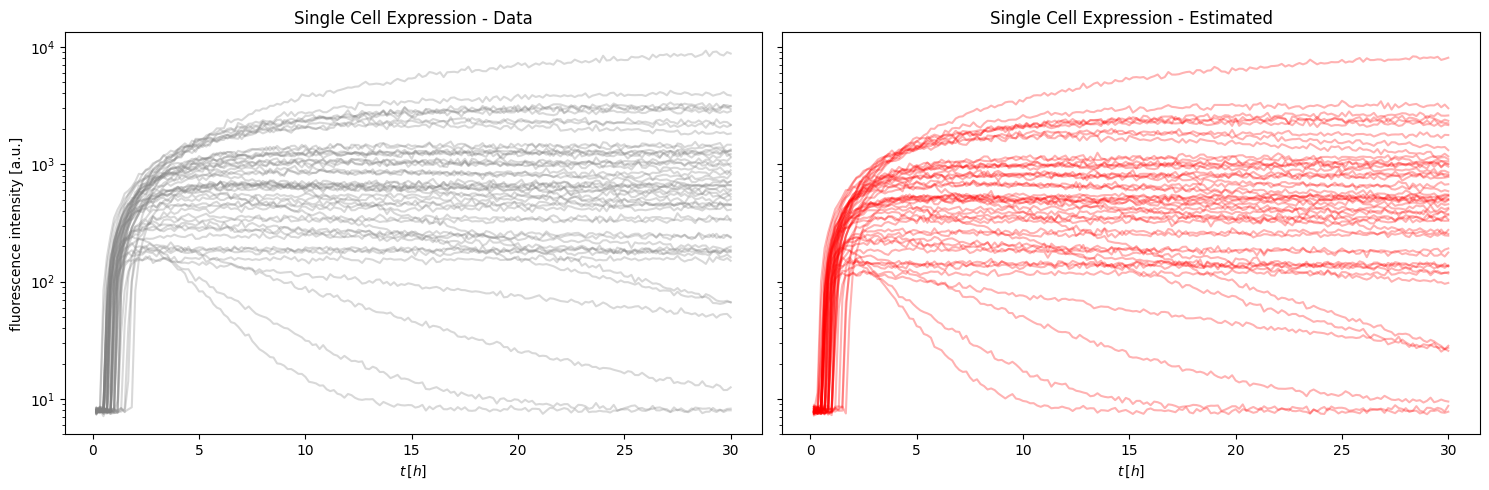

In [17]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           seed=0)
    
    if n_covariates_params > 0:
        print(estimated_covariates_params)
        estimated_beta_d2, estimated_inv_psi_d2 = covariate_mapping(estimated_beta, 
                                                                    estimated_psi_vector, 
                                                                    np.ones(1), 
                                                                    estimated_covariates_params)
        print(estimated_beta[1], estimated_beta_d2[0, 1])
        estimated_beta_d2 = estimated_beta_d2[-1]  # only second group, mean is the same for the whole group
        estimated_inv_psi_d2 = estimated_inv_psi_d2[-1]
        estimated_psi_d2 = np.linalg.inv(estimated_inv_psi_d2)
        
        plot_real_vs_synthetic(estimated_mean=estimated_beta_d2,
                           estimated_cov=estimated_psi_d2,
                           data=obs_data[n_data//2:],
                           model_name=individual_model.name,
                           n_trajectories=n_data//2,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
        plot_real_and_estimated(estimated_mean=estimated_beta_d2,
                               estimated_cov=estimated_psi_d2,
                               data=obs_data[n_data//2:],
                               model_name=individual_model.name,
                               n_trajectories=n_data//2,
                               simulator=individual_model.simulator,
                               seed=0)

# Bayesian Sampling

Since our amortized inference is very efficient, we can use it to sample from the posterior distribution of the population parameters.

In [18]:
# build neg log prior
inv_var_prior_mean = -np.log(individual_model.prior_cov.diagonal())
inv_var_prior_std = np.ones(len(inv_var_prior_mean))*5
prior = NegLogParameterPriors(
    [
        {'index': pesto_problem.full_index_to_free_index(i), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=individual_model.prior_mean[i], scale=np.sqrt(individual_model.prior_cov.diagonal()[i]))}
     for i in range(individual_model.n_params) if i not in fixed_indices
    ] + [
        {'index': pesto_problem.full_index_to_free_index(i+individual_model.n_params), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=inv_var_prior_mean[i], scale=inv_var_prior_std[i])}
     for i in range(individual_model.n_params) if i+individual_model.n_params not in fixed_indices
    ] + [
        {'index': pesto_problem.full_index_to_free_index(i+individual_model.n_params*2), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=0, scale=1)}
     for i in range(len(mixed_effect_params_names)-individual_model.n_params*2) if i+individual_model.n_params*2 not in fixed_indices
    ]
)

In [19]:
bayesian_problem = Problem(
    objective=AggregatedObjective([Objective(obj_fun_amortized), prior]),
    lb=pesto_problem.lb_full, 
    ub=pesto_problem.ub_full, 
    x_names=pesto_problem.x_names,
    x_scales=pesto_problem.x_scales,
    x_fixed_indices=pesto_problem.x_fixed_indices,
    x_fixed_vals=pesto_problem.x_fixed_vals,
    x_priors_defs=prior,
)

In [20]:
sampler = sample.AdaptiveMetropolisSampler()
x0 = pesto_problem.get_reduced_vector(pypesto_result.optimize_result.x[0])

In [22]:
pypesto_result = sample.sample(
    bayesian_problem,
    n_samples=10000,
    sampler=sampler,
    result=pypesto_result,
    x0=x0,
    #filename=f'../Experiments/results_nonmem/sampling_{model_name}_{cov_type}.hdf5',
    overwrite=True
)

100%|██████████| 10000/10000 [00:13<00:00, 759.91it/s]
Elapsed time: 29.399283999999994
INFO:pypesto.sample.sample:Elapsed time: 29.399283999999994


Geweke burn-in index: 8000
INFO:pypesto.sample.diagnostics:Geweke burn-in index: 8000


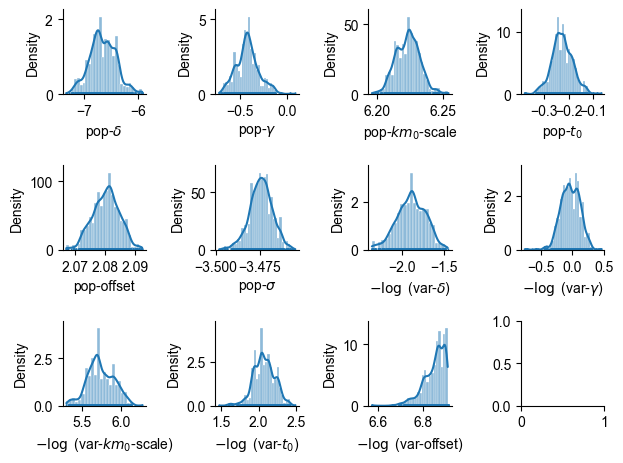

In [23]:
sample.geweke_test(pypesto_result)
ax = visualize.sampling_1d_marginals(pypesto_result)

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    #min_step_size=0.0001, #0.001
    #step_size_factor=1.25, #1.25
    delta_ratio_max=0.01, #0.1
    #default_step_size=0.0001, #0.01
    #ratio_min=0.145 #0.145
)

pypesto_result = profile.parameter_profile(
    problem=pypesto_result.problem,
    result=pypesto_result,
    optimizer=optimize.ScipyOptimizer(), #(options={'disp': True}),
    engine=engine.MultiProcessEngine(10),
    #profile_options=profile_options,
    #filename=f'../Experiments/synthetic_results_amortized/uncertainty_{individual_model.name}_cells_{n_data}_samples_{100}.hd5',
    #overwrite=True
)

In [ ]:
visualize.profiles(pypesto_result, size=(16,12), 
                   profile_list_ids=list(np.arange(len(pypesto_result.profile_result.list)))
)
plt.show()

In [ ]:
ax = visualize.profile_cis(pypesto_result, profile_list=len(pypesto_result.profile_result.list)-1)
#ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
plt.show()

Uncertainty based on FIM

In [ ]:
pypesto_result = profile.approximate_parameter_profile(
    problem=pypesto_result.problem,
    result=pypesto_result,
)

In [ ]:
visualize.profiles(pypesto_result, 
                   profile_list_ids=list(np.arange(len(pypesto_result.profile_result.list)))
                   )
plt.show()

In [ ]:
ax = visualize.profile_cis(pypesto_result, profile_list=len(pypesto_result.profile_result.list)-1)
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
plt.show()